<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/09_PyTorch_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment.


## 1. Getting Data

The dataset we are going to use is the known: Pizza, steak, sushi 20% dataset from Food101.

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 35.63 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


Set up device agnostic code first:

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup training and test paths
train_dir = data_20_percent_path  / 'train'
test_dir = data_20_percent_path  / 'test'

train_dir, test_dir


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment outline

### 3 Questions
1. What is my most ideal ML model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

** FoodVision Mini ideal use case:** A model that performs well and fast.

* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
 * Latency = time for prediction to take place

To try and achieve these goals, we are going to build two model experiments:

1. EffNetB2 feature extractor
2. ViT feature extractor

## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has it base layers frozen and output (or head) leayers customized to fit a certain problem.

In [5]:
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [6]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # aka the latest best weights

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup a pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

# 5. Customizing the classifier
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=3),
    nn.Linear(in_features=1408, out_features=3,bias=True)
)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 124MB/s]


In [7]:
### 3.1 Creating a function to make an EffNetB2 feature extractor

In [8]:
def create_effnetb2_model(num_classes:int=3, # default
                          seed:int=42):
  # 1,2,3 steps above: Create weights, transforms,
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze the layers
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change the classifier head
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3,inplace=True),
      nn.Linear(in_features=1408,
                out_features = num_classes)
  )

  return model, transforms

In [9]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

In [10]:
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.2 Creating DataLoaders for EffNetB2


In [11]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names =  data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                  test_dir = test_dir,
                                                                                                  transform = effnetb2_transforms,
                                                                                                  batch_size = 32)
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [12]:
from going_modular.going_modular import engine
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                            lr = 1e-3)

# Training function
set_seeds()
effnetb2_results = engine.train(model = effnetb2,
                                train_dataloader = train_dataloader_effnetb2,
                                test_dataloader = test_dataloader_effnetb2,
                                epochs = 10,
                                loss_fn = loss_fn,
                                optimizer = optimizer,
                                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### 3.4 Inspecting EffNetB2 loss curves

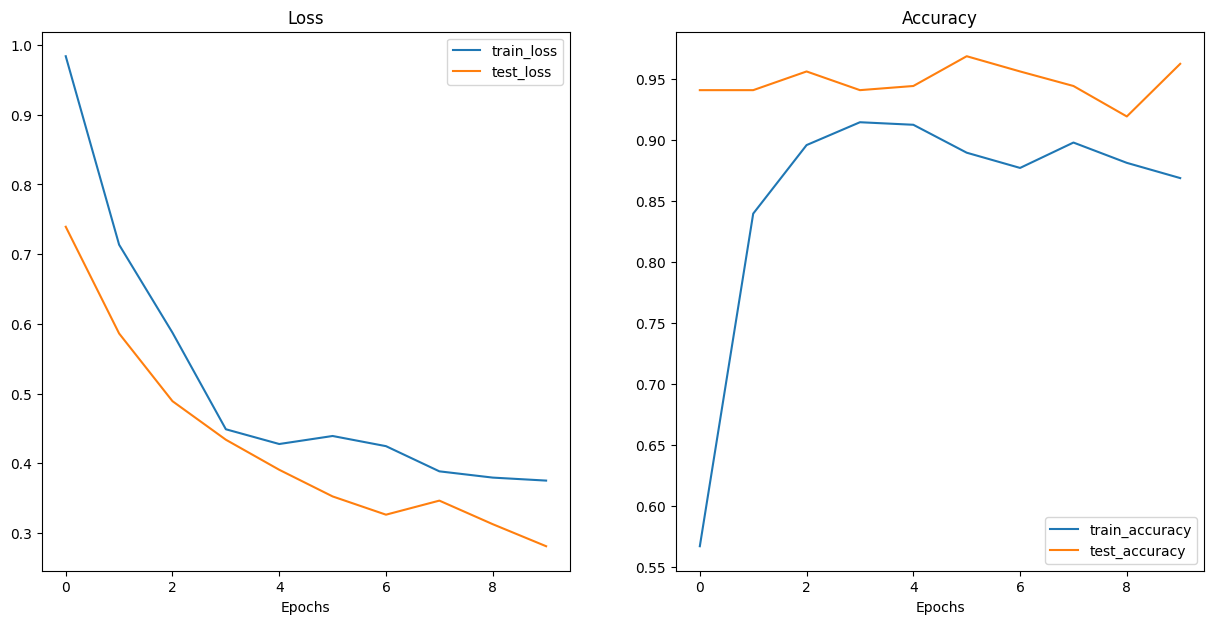

In [13]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [14]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir = 'models',
                 model_name = "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor

It is important to know the size of the model, since we want to deploy it.

In [15]:
from pathlib import Path

pretrained_effnetb2_model_size = Path('models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size // (1024 * 1024)
print(f"pretrained effnetb2 model size: {pretrained_effnetb2_model_size} MB")

pretrained effnetb2 model size: 29 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [16]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [17]:
# Create a dict with EffNetB2 stats
effnetb2_stats = {"test_loss":effnetb2_results['test_loss'][-1],
                  "test_acc":effnetb2_results['test_acc'][-1],
                  'total_params':effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28108683228492737,
 'test_acc': 0.9625,
 'total_params': 7705221,
 'model_size (MB)': 29}

## 4. Create a ViT feature extractor

We will create a 2nd modelling experiment, this time with ViT feature extreactor.

In [18]:
# Check out the heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [19]:
def create_vit_model(num_classes:int = 3,
                     seed:int=42):
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

  # Freeze all of the base layers
  for param in model.parameters():
    param.requires_grad = False

  # Change the classifier head
  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features = 768,
                                        out_features = num_classes))
  return model, transforms

In [20]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 215MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [21]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [22]:
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                       test_dir = test_dir,
                                                                                       transform = vit_transforms,
                                                                                       batch_size = 32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT

In [23]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 1e-3 )
loss_fn  = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader = train_dataloader_vit,
                           test_dataloader = test_dataloader_vit,
                           epochs = 10,
                           optimizer = optimizer,
                           loss_fn = loss_fn,
                           device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plotting loss curves

### 4.4 Saving ViT featrure extractor

In [24]:
from going_modular.going_modular import utils
utils.save_model(model=vit,
                 target_dir = 'models',
                 model_name = '09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of the ViT model


In [25]:
from pathlib import Path

pretrained_vit_model_size = Path('models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size // (1024 * 1024)
print(f"pretrained vit model size: {pretrained_vit_model_size} MB")

pretrained vit model size: 327 MB


### 4.6 Collecting ViT stats

In [26]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params
vit_stats = {"test_loss":vit_results['test_loss'][-1],
                  "test_acc":vit_results['test_acc'][-1],
                  'total_params':vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'total_params': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with our trained models

Our goal:
1. Performs well (95%+ test accuracy)
2. Is fast

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make predictions

Let's create a function called `pred_and_store()` to do so.

In [27]:
from pathlib import Path

# get all test data paths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/833711.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/296426.jpg')]

## 5.1 Creating a function to make prediction across the test dataset

1. Create a function that takes a list of paths and trained PyTorch and a series of transforms, a list of target class names and a target device.
2. Create an empty list
3. Loop through the target input paths
4. Create an empty dir for each sqample (pred stats will go in here)
5. Get the sample path and ground truth class from the filepath/
6. Start the timer.
7. Open the image using `PIL.Image.open(path)`
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empy dict from step 4.
12. End the timer and add the time to the pred dict.
13. Compare the predicted classes with the ground truth classes.
14. Append the updated prediction dict to the empty list of preds in step 2.
15. Return the list


In [38]:
import torch
import pathlib

from timeit import default_timer as timer
from PIL import Image
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths:List[pathlib.Path],
                   model: torch.nn.Module,
                   transform:torchvision.transforms,
                   class_names:List[str],
                   device:str='cuda' if torch.cuda.is_available() else 'cpu') -> List[Dict]:
  # 2. Create an empty list
  pred_list = []

  # 3
  for path in tqdm(paths):

    # 4
    pred_dict = {}

    # 5
    pred_dict['image_path'] = path
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    # 6
    start_time = timer()

    # 7
    img = Image.open(path)

    #8
    transformed_image = transform(img).unsqueeze(0).to(device) # adding a batch dimension as well

    #9
    model = model.to(device)
    model.eval()

    #10
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit,dim=1) # Turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probability into prediction label (basically an index)
      pred_class = class_names[pred_label.cpu()] # hardcode predicition class to be on CPU (python variables live on cpu)

      # 11
      pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(),4)
      pred_dict['pred_class'] = pred_class

      # 12
      end_time = timer()
      pred_dict['time_for_pred'] = round(end_time - start_time,4)

      # 13
      pred_dict['correct'] = class_name == pred_class

      # 14
      pred_list.append(pred_dict)
  # 15
  return pred_list

## 5.2 Making predictions with EffNetB2

In [39]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [41]:
# Turn the preds dict into a DataFrame
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9941,pizza,0.1127,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8142,pizza,0.1028,True
2,data/pizza_steak_sushi_20_percent/test/pizza/8...,pizza,0.6413,pizza,0.1099,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.6982,pizza,0.0995,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8495,pizza,0.1025,True


In [42]:
# Check number of correct preds
effnetb2_test_pred_df.correct.value_counts()

True     144
False      6
Name: correct, dtype: int64

In [44]:
# Find the average time per prediction
average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(),4)
print(f"Average time per prediction: {average_time_per_pred}s")

Average time per prediction: 0.1287s


> **NOTE:** Pred times will vary depending on the hardware. So, generally, the faster the compute ( CPU / GPU) the faster the preds.